# CLIP (Contrastive Language-Image Pre-training))
[A. Radford, J. W. Kim, C. Hallacy, et al., "Learning Transferable Visual Models from Natural Language Supervision" arXiv, 2021.](https://arxiv.org/abs/2103.00020)

* New approch to link images and texts, enabling scalable supervised learning by using natural language

* Contrastive pre-training
  1. Extract feature representations of each modality.
```
I_f = image_encoder(image) # [N, D_i]
T_f = text_encoder(text)   # [N, D_t]
```
```
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)
```

  2. Calculate the cosin similarity for each pair.
```
logits = np.dot(I_e, T_e.T) * np.exp(t)  # [N, N]
```

  3. Campute the cross-entropy using symmetric loss function.
```
labels = np.arange(n)
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2
```

* Zero-shot prediction
  1. Create a list of label text: `A photo of a {class_name}`
  2. Extract feature representations from input images and the above text list<br>
     and calculate the similarity for each label text
  3. Pick the text with highest score as the answer


In [ ]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive')

DATA_ROOT= Path('./data/')
MODEL_ROOT = DRIVE_ROOT / 'weights'

!mkdir -p {DATA_ROOT}
!mkdir -p {MODEL_ROOT}

Mounted at /content/drive


In [ ]:
%pip install -q matplotlib torchviz torchinfo
%pip -q install "git+https://github.com/openai/CLIP.git"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, models, ops, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

def get_device():
    '''Get device (CPU or GPU).'''
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Quick Hands-on with CLIP Zero-shot Prediction

In [ ]:
!rsync -auv --info=progress2 {DRIVE_ROOT}/datasets/food-101.tar.gz {DATA_ROOT}/
food_dataset = datasets.Food101(root=DATA_ROOT, download=True)
classes = food_dataset.classes

sending incremental file list
food-101.tar.gz

sent 4,997,498,228 bytes  received 35 bytes  36,345,441.91 bytes/sec
total size is 4,996,278,331  speedup is 1.00


In [ ]:
@torch.inference_mode()
def predict(model, image, texts, device=get_device()):
    """ Predict the similarity between an input image and candidate texts.

    Args:
        model: Inference model.
        image: Input image [C, H, W].
        texts: List of candidate text.
    Returns:
        torch.Tensor: Probability scores over the text candidates [N_class].
    """
    model.eval()
    model.to(device)

    # Extract feature representations of input image.
    image = image.unsqueeze(0).to(device)  # [1, C, H, W]
    image_f = model.encode_image(image)    # [1, D]
    image_f /= image_f.norm(dim=-1, keepdim=True)

    # Extract feature representations of input text
    tokens = clip.tokenize(texts).to(device)  # [N_class, token_length]
    texts_f = model.encode_text(tokens)       # [N_class, D]
    texts_f /= texts_f.norm(dim=-1, keepdim=True)

    # Compute the cosine similarity between the encoded image and text.
    scale_factor = model.logit_scale.exp()
    logits = (image_f @ texts_f.T).squeeze(0) * scale_factor  # [N_class]
    scores = logits.softmax(dim=-1)                           # [N_class]
    return scores.cpu()


def visualize(image, label, texts, scores, figsize=(6,3), topk=5):
    """ Visualize an input image and picked up topk candidate.

    Args:
        image: Input image [C, H, W].
        texts: List of candidate text.
        scores: Probability scores over the text candidates [N_class].
    """
    top_scores, top_idx = scores.topk(topk)

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 2], wspace=0.05)

    ax_img = fig.add_subplot(gs[0])
    ax_img.imshow(image)
    ax_img.axis("off")

    ax_txt = fig.add_subplot(gs[1])
    captions = [
        f"Ground Truth:",
        texts[label],
        '\n',
        'Prediction:',
    ] + [f"{i+1}. {texts[top_idx[i]]}: {top_scores[i]:.2f}" for i in range(topk)]
    ax_txt.text(0, 1, '\n'.join(captions), ha="left", va="top")
    ax_txt.axis("off")

    plt.show()

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 41.6MiB/s]


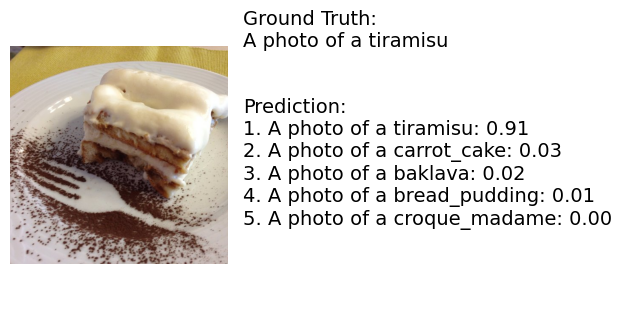

In [ ]:
import clip
import random

# Pick a pair of image and text randomly.
rand_idx = random.randrange(len(food_dataset))
image, label = food_dataset[rand_idx]

# Prepare description candidates.
texts = [f"A photo of a {class_name}" for class_name in classes]

model, preprocess = clip.load("ViT-B/32")
scores = predict(model, preprocess(image), texts)
visualize(image, label, texts, scores)

## Contrastive pre-training

In [ ]:
class ImageTransform():
    def __init__(self, size: int=224, mean: tuple=(0.4914, 0.4822, 0.4465), std: tuple=(0.2470, 0.2435, 0.2616)):
        self.transform = transforms.Compose([
            transforms.Resize(size=size, interpolation=Image.BICUBIC, antialias=True),
            transforms.CenterCrop(size=(size, size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

    def __call__(self, image):
        return self.transform(image)

In [ ]:
from torch import nn
import torchvision

class VisionEncoder(nn.Module):
    def __init__(self, emb_dim=512, pretrained=True):
        super().__init__()
        self.vision_encoder = torchvision.models.vit_b_32(pretrained=pretrained)
        hidden_dim = self.vision_encoder.heads[-1].in_features
        self.vision_encoder.heads = nn.Linear(hidden_dim, emb_dim, bias=False)

    def forward(self, x):
        return self.vision_encoder(x)

vision_encoder = VisionEncoder()
image_t = ImageTransform()(image).unsqueeze(0)  # [1, C, H, W]
x = vision_encoder(image_t)
x.shape

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth


100%|██████████| 337M/337M [00:06<00:00, 55.9MB/s]


torch.Size([1, 512])

In [ ]:
from transformers import CLIPTokenizerFast

class CLIPTokenizer:
    """ Tokenizer for CLIP."""
    def __init__(self, model_name="openai/clip-vit-base-patch32"):
        self.tokenizer = CLIPTokenizerFast.from_pretrained(model_name)

    def __call__(self, text: str):
        return self.tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")['input_ids']

    @property
    def vocab_size(self) -> int:
        """ Return the number of vocabulary in this model (= The number of token class)."""
        return self.tokenizer.vocab_size

tokenizer = CLIPTokenizer()
display(tokenizer('This is a photo of dog.'))
display(tokenizer('This is a photo of frog, but it looks bird.'))
tokenizer.vocab_size

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tensor([[49406,   589,   533,   320,  1125,   539,  1929,   269, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

tensor([[49406,   589,   533,   320,  1125,   539, 11438,   267,   767,   585,
          1606,  3329,   269, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

49408

In [ ]:
from dataclasses import dataclass

@dataclass
class ModelParameter:
    """ Parameters for CLIP."""
    context_length: int = 77
    embed_dim: int = 512   # Output dimension.
    text_width: int = 512  # Hidden dimension in Transformer.
    text_layers: int = 12  # Number of layers in Transformer.
    text_heads: int = 8    # Number of heads in Transformer.
    ffn_coef: int = 4      # FFN coefficient
    dropout_rate: float = 0.0


class TextEncoder(nn.Module):
    def __init__(self, vocab_size: int, param: ModelParameter):
        super().__init__()
        self.token_embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=param.text_width,
            padding_idx=0,
        )
        self.positional_embedding = nn.Parameter(
            torch.empty(param.context_length, param.text_width))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=param.text_width,
            nhead=param.text_heads,
            dim_feedforward=param.ffn_coef * param.text_width,
            dropout=param.dropout_rate,
            activation="gelu",
            batch_first=False,
            norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=param.text_layers)

        self.layer_norm = nn.LayerNorm(param.text_width)
        self.text_projection = nn.Parameter(torch.empty(param.text_width, param.embed_dim))

        # Initialize network parameters.
        self.reset_parameter(param.text_width)

    def reset_parameter(self, text_width):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)
        nn.init.normal_(self.text_projection, std=text_width ** -0.5)

    def forward(self, tokens):
        """
        Args:
            x: Input tokens (B, L), where
                B: Batch size.
                L: Context length.
        Returns:
            torch.Tensor: (B, E), where
                E: Embedding dimension.
        """
        x = tokens

        # (B, L, D), where D denotes the hidden dimensions in Transformer.
        x = self.token_embedding(x)
        x = x + self.positional_embedding

        # (B, L, D) -> (L, B, D)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)

        # (L, B, D) -> (B, L, D)
        x = x.permute(1, 0, 2)
        x = self.layer_norm(x)

        # Pick up the position of EOT (= The highest number in each sequence.)
        eot_idx = tokens.argmax(dim=-1)              # [B]
        x = x[torch.arange(x.shape[0]), eot_idx]   # [B, D]

        # Project to output.
        x = x @ self.text_projection               # [B, D] @ [D, E] -> [B, E]
        return x

tokenizer = CLIPTokenizer()
text_encoder = TextEncoder(vocab_size=tokenizer.vocab_size, param=ModelParameter())
tokens = tokenizer('This is a photo of frog.')
x = text_encoder(tokens)
x.shape

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([1, 512])

In [ ]:
class CLIP(nn.Module):
    def __init__(self, vocab_size: int, param: ModelParameter):
        super().__init__()
        self.vision_encoder = VisionEncoder(emb_dim=param.embed_dim)
        self.text_encoder = TextEncoder(vocab_size=vocab_size, param=param)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def encode_image(self, image):
        return self.vision_encoder(image)

    def encode_text(self, text):
        return self.text_encoder(text)

    def forward(self, image, text):
        image_f = self.encode_image(image)
        text_f = self.encode_text(text)

        # normalized features
        image_f = image_f.norm(dim=-1, keepdim=True)
        text_f = text_f.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp().clamp(max=100.0)
        logits_per_image = logit_scale * image_f @ text_f.t()
        logits_per_text = logits_per_image.t()
        return logits_per_image, logits_per_text

model = CLIP(vocab_size=tokenizer.vocab_size, param=ModelParameter())
model(image_t, tokens)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(tensor([[2675.2236]], grad_fn=<MmBackward0>),
 tensor([[2675.2236]], grad_fn=<TBackward0>))

In [ ]:
%pip install -q huggingface_hub

In [ ]:
!rsync -auv --info=progress2 {DRIVE_ROOT}/datasets/flickr30k-images.zip {DATA_ROOT}/

In [ ]:
from huggingface_hub import snapshot_download
import json
import pandas as pd
import zipfile

class Flikr30kDataset(Dataset):
    REPO_ID = "nlphuji/flickr30k"
    IMAGE_DIRNAME = "flickr30k-images"
    ANN_CSV_FILE = "flickr_annotations_30k.csv"
    ANN_TSV_FILE = "flickr_annotation_{split}_30k.csv"

    def __init__(self, root: Path, phase='train', transform=None):
        self._download_dataset(root)

        input_filepath = root / self.ANN_CSV_FILE
        self._convert_csv_to_ann(input_filepath, root)

        image_dirpath = root / self.IMAGE_DIRNAME
        ann_filepath = root / self.ANN_TSV_FILE.format(split=phase)
        self.dataset = datasets.Flickr30k(root=image_dirpath, ann_file=ann_filepath, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def _download_dataset(self, root: Path):
        zip_path = root / (self.IMAGE_DIRNAME + ".zip")
        if (root/self.IMAGE_DIRNAME).exists():
            return

        snapshot_download(self.REPO_ID, local_dir=root, repo_type="dataset")
        with zipfile.ZipFile(zip_path) as zf:
            zf.extractall(root)

    def _convert_csv_to_ann(self, input_file: Path, output_dir: Path):
        df = pd.read_csv(input_file)
        df = df[['filename', 'raw', 'split']].dropna().astype(str)
        df['filename'] += '#0'
        df['raw'] = df['raw'].apply(lambda x: json.loads(x))
        df = df.explode('raw').reset_index(drop=True)

        for split, group in df.groupby('split'):
            output_filepath = output_dir / self.ANN_TSV_FILE.format(split=split)
            group[["filename", "raw"]].to_csv(output_filepath, sep='\t', index=False)

dataset = Flikr30kDataset(DATA_ROOT)

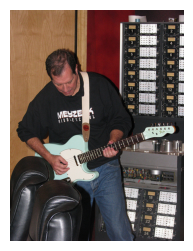

A man in black and blue plays a powder blue rock guitar in a studio.
A White man is playing a guitar in a recording studio.
An middle-aged man plays a light blue, fender guitar.
A man in a black sweatshirt plays a guitar.
A man playing his guitar.


In [ ]:
import random
image, captions = dataset[random.randrange(len(dataset))]

plt.imshow(image)
plt.axis('off')
plt.show()

for caption in captions:
    print(caption)